In [1]:
!conda install -y --freeze-installed pandas matplotlib scipy

Solving environment: done

## Package Plan ##

  environment location: /home/seagetch/anaconda3/envs/covid19

  added / updated specs:
    - matplotlib
    - pandas
    - scipy


The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge::certifi-2020.12.5-py39hf~ --> pkgs/main::certifi-2020.12.5-py39h06a4308_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [2]:
import pandas as pd
import csv
import os,sys,json
from datetime import datetime, timedelta, date
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.pylab as plt
import re
#from pylab import *
import tqdm
import numpy as np
%matplotlib inline
font = {'family' : 'Noto Sans CJK JP'}
matplotlib.rc('font', **font)

In [3]:
%%html

<style>
    .jp-OutputArea-child {
        display: inline-block;
    }
</style>

In [4]:
def display_full(df):
    max_rows = pd.get_option('display.max_rows')
    pd.set_option('display.max_rows', None)
    display(df)
    pd.set_option('display.max_rows', max_rows)

In [5]:
!mkdir -p data/google/forecasts
!wget https://storage.googleapis.com/covid-external/forecast_JAPAN_PREFECTURE_28.csv -O data/google/forecasts/forecast_JAPAN_PREFECTURE_28-`date +%Y%m%d`.csv

--2021-05-10 19:44:26--  https://storage.googleapis.com/covid-external/forecast_JAPAN_PREFECTURE_28.csv
storage.googleapis.com (storage.googleapis.com) をDNSに問いあわせています... 2404:6800:4004:80c::2010, 2404:6800:4004:80d::2010, 2404:6800:4004:809::2010, ...
storage.googleapis.com (storage.googleapis.com)|2404:6800:4004:80c::2010|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 459670 (449K) [application/octet-stream]
`data/google/forecasts/forecast_JAPAN_PREFECTURE_28-20210510.csv' に保存中

data/google/forecas 100%[===================>] 448.90K  --.-KB/s    in 0.06s   

2021-05-10 19:44:27 (7.82 MB/s) - `data/google/forecasts/forecast_JAPAN_PREFECTURE_28-20210510.csv' へ保存完了 [459670/459670]



In [6]:
target_date = datetime.now().strftime("%Y%m%d")
df = pd.read_csv("data/google/forecasts/forecast_JAPAN_PREFECTURE_28-%s.csv"%target_date)
df.set_index("target_prediction_date").sort_index()

,japan_prefecture_code,prefecture_name,cumulative_confirmed,cumulative_confirmed_q0025,cumulative_confirmed_q0975,cumulative_deaths,cumulative_deaths_q0025,cumulative_deaths_q0975,hospitalized_patients,hospitalized_patients_q0025,...,cumulative_confirmed_ground_truth,cumulative_deaths_ground_truth,hospitalized_patients_ground_truth,recovered_ground_truth,forecast_date,new_deaths,new_confirmed,new_deaths_ground_truth,new_confirmed_ground_truth,prefecture_name_kanji
target_prediction_date,,,,,,,,,,,,,,,,,,,,,
2021-04-09,JP-02,AOMORI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1144.0,20.0,174.0,950.0,2021-05-06,NaN,NaN,NaN,NaN,青森県
2021-04-09,JP-40,FUKUOKA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19314.0,334.0,416.0,18550.0,2021-05-06,NaN,NaN,NaN,NaN,福岡県
2021-04-09,JP-35,YAMAGUCHI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1448.0,43.0,43.0,1369.0,2021-05-06,NaN,NaN,NaN,NaN,山口県
2021-04-09,JP-09,TOCHIGI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4891.0,70.0,256.0,4565.0,2021-05-06,NaN,NaN,NaN,NaN,栃木県
2021-04-09,JP-21,GIFU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4984.0,129.0,173.0,4796.0,2021-05-06,NaN,NaN,NaN,NaN,岐阜県
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-03,JP-36,TOKUSHIMA,1641.708862,1618.856323,2149.200684,75.934418,74.555412,102.618149,189.679398,183.327576,...,NaN,NaN,NaN,NaN,2021-05-06,0.808662,6.495850,NaN,NaN,徳島県
2021-06-03,JP-14,KANAGAWA,60694.472656,59997.750000,70123.437500,888.664368,872.643188,1197.986328,2218.027588,2143.684082,...,NaN,NaN,NaN,NaN,2021-05-06,3.795349,262.886719,NaN,NaN,神奈川県
2021-06-03,JP-37,KAGAWA,1518.307617,1498.341187,1944.706787,31.960917,31.382071,43.162304,162.358002,156.922287,...,NaN,NaN,NaN,NaN,2021-05-06,0.245699,2.419189,NaN,NaN,香川県


In [7]:
df.columns

Index(['japan_prefecture_code', 'prefecture_name', 'target_prediction_date',
       'cumulative_confirmed', 'cumulative_confirmed_q0025',
       'cumulative_confirmed_q0975', 'cumulative_deaths',
       'cumulative_deaths_q0025', 'cumulative_deaths_q0975',
       'hospitalized_patients', 'hospitalized_patients_q0025',
       'hospitalized_patients_q0975', 'recovered', 'recovered_q0025',
       'recovered_q0975', 'cumulative_confirmed_ground_truth',
       'cumulative_deaths_ground_truth', 'hospitalized_patients_ground_truth',
       'recovered_ground_truth', 'forecast_date', 'new_deaths',
       'new_confirmed', 'new_deaths_ground_truth',
       'new_confirmed_ground_truth', 'prefecture_name_kanji'],
      dtype='object')

In [8]:
#total_df = df.loc[~df["new_confirmed"].isnull()].groupby("target_prediction_date").sum()
total_df = df.groupby("target_prediction_date").sum()
total_df

,cumulative_confirmed,cumulative_confirmed_q0025,cumulative_confirmed_q0975,cumulative_deaths,cumulative_deaths_q0025,cumulative_deaths_q0975,hospitalized_patients,hospitalized_patients_q0025,hospitalized_patients_q0975,recovered,recovered_q0025,recovered_q0975,cumulative_confirmed_ground_truth,cumulative_deaths_ground_truth,hospitalized_patients_ground_truth,recovered_ground_truth,new_deaths,new_confirmed,new_deaths_ground_truth,new_confirmed_ground_truth
target_prediction_date,,,,,,,,,,,,,,,,,,,,
2021-04-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,497688.0,9361.0,28744.0,458330.0,0.000000,0.000000,0.0,0.0
2021-04-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,501433.0,9388.0,29558.0,461063.0,0.000000,0.000000,27.0,3745.0
2021-04-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,504272.0,9405.0,30327.0,463154.0,0.000000,0.000000,17.0,2839.0
2021-04-12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,506358.0,9429.0,29885.0,466051.0,0.000000,0.000000,24.0,2086.0
2021-04-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,509797.0,9474.0,30920.0,468268.0,0.000000,0.000000,45.0,3439.0
2021-04-14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,514094.0,9507.0,32198.0,470842.0,0.000000,0.000000,33.0,4297.0
2021-04-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,518658.0,9542.0,34543.0,473021.0,0.000000,0.000000,35.0,4564.0
2021-04-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,523171.0,9588.0,36493.0,475633.0,0.000000,0.000000,46.0,4513.0
2021-04-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,527956.0,9629.0,38600.0,478013.0,0.000000,0.000000,41.0,4785.0


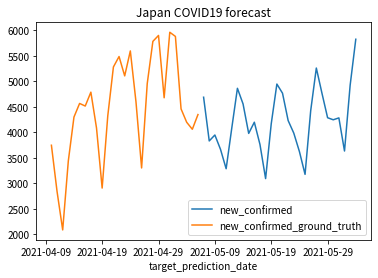

In [9]:
!mkdir -p google-covid19-forecast/jp
ax=total_df.replace(0, np.nan).plot(title="Japan COVID19 forecast", y=["new_confirmed","new_confirmed_ground_truth"])
display(ax.figure)
plt.savefig("google-covid19-forecast/jp/total.png")
plt.close()

In [10]:
if False:
    for p, ddf in df.groupby("prefecture_name"):
        ax=ddf.set_index("target_prediction_date").sort_index().plot(title=p, y=["new_confirmed","new_confirmed_ground_truth"])
        display(ax.figure)
        plt.savefig("google-covid19-forecast/jp/%s.png"%p)
        plt.close()

In [14]:
from functools import reduce

def read_one_week():
    today = datetime.now()
    stable_cols = ("target_prediction_date", "prefecture_name", "new_confirmed_ground_truth")
    def data_for_date(target_date):
        filename = "data/google/forecasts/forecast_JAPAN_PREFECTURE_28-%s.csv"%target_date
        if not os.path.exists(filename):
            return None
        ddf = pd.read_csv(filename)
        result = ddf[[
            "target_prediction_date", "prefecture_name", 
            "new_confirmed_ground_truth", "new_confirmed"]]
        result["target_prediction_date"] = pd.to_datetime(result["target_prediction_date"])
        columns={ 
            c: "%s_%s"%(c, target_date) if c not in stable_cols else c for c in result.columns 
        }
        result = result.rename(columns=columns)
        return result
    
    dates = [(today - timedelta(days=i)).strftime("%Y%m%d") for i in range(6, -1, -1)]
    data  = [data_for_date(d) for d in dates]
    truth = [d[1].set_index(['target_prediction_date', 'prefecture_name'])["new_confirmed_ground_truth"].rename(d[0]) for d in zip(dates, data) if not d[1] is None]
    truth = reduce(lambda l, r: pd.merge(l, r, on=['target_prediction_date', 'prefecture_name'], how='outer'), truth)
    if len(truth.shape) > 1 and truth.shape[-1] > 1:
        truth = truth.max(axis=1)
    truth = truth.reset_index().set_index("target_prediction_date").sort_index()
    truth_avg = truth.groupby("prefecture_name").rolling(7, center=True, min_periods=1).mean()
    truth_avg = truth_avg.reset_index().set_index(["target_prediction_date", "prefecture_name"]).sort_index()
    truth = truth.reset_index().set_index(["target_prediction_date", "prefecture_name"]).sort_index()
    truth = pd.concat([truth,truth_avg], axis=1, ignore_index=True)
    truth = truth.rename(columns={0: "new_confirmed", 1: "new_confirmed(avg)"})
    data = [d.drop(columns="new_confirmed_ground_truth") for d in data if not d is None]
    data = [truth] + data
    return reduce(lambda l, r: pd.merge(l, r, on=['target_prediction_date', 'prefecture_name'], how='outer'), data)
weekly_comparison = read_one_week()
display(weekly_comparison)

<ipython-input-14-0939befd48b1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result["target_prediction_date"] = pd.to_datetime(result["target_prediction_date"])


,target_prediction_date,prefecture_name,new_confirmed,new_confirmed(avg),new_confirmed_20210510
0,2021-04-09,AICHI,NaN,149.333333,NaN
1,2021-04-09,AKITA,NaN,5.000000,NaN
2,2021-04-09,AOMORI,NaN,11.000000,NaN
3,2021-04-09,CHIBA,NaN,98.333333,NaN
4,2021-04-09,EHIME,NaN,24.666667,NaN
...,...,...,...,...,...
2627,2021-06-03,TOYAMA,NaN,NaN,5.448486
2628,2021-06-03,WAKAYAMA,NaN,NaN,23.042236
2629,2021-06-03,YAMAGATA,NaN,NaN,8.972412
2630,2021-06-03,YAMAGUCHI,NaN,NaN,11.427734


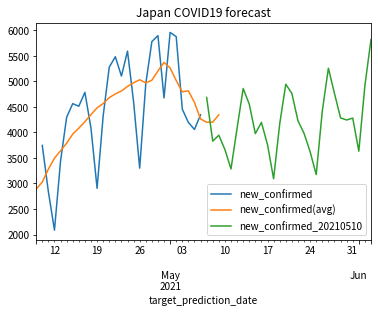

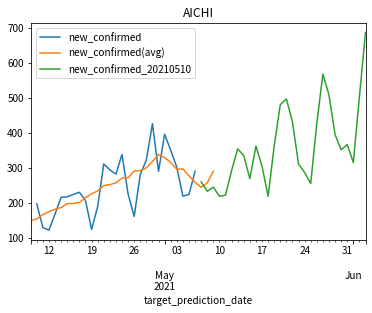

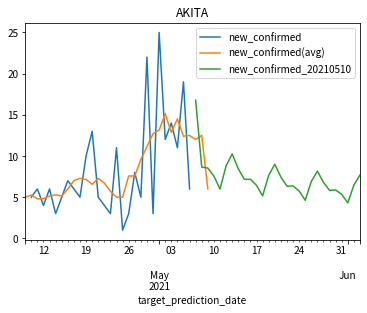

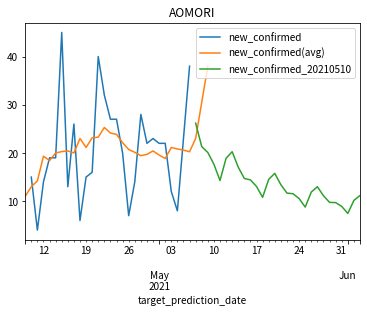

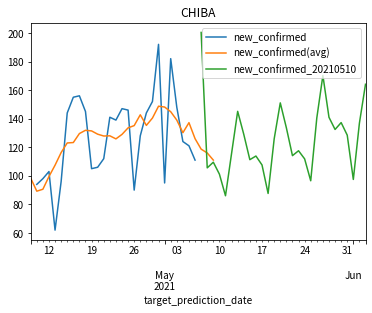

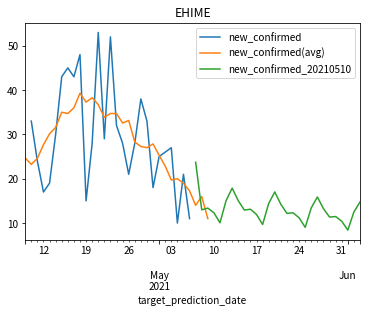

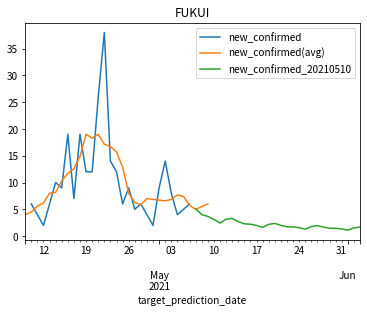

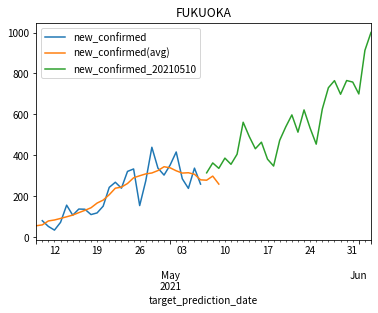

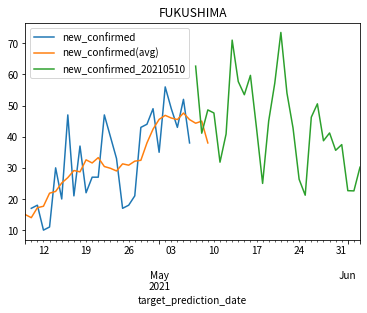

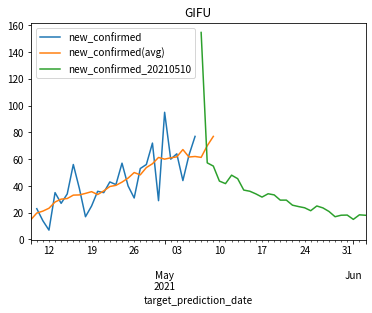

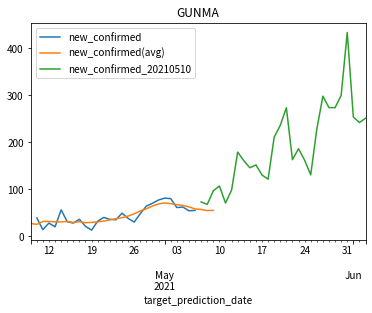

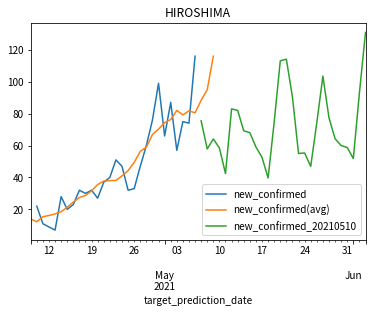

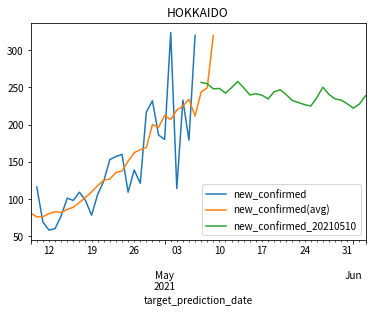

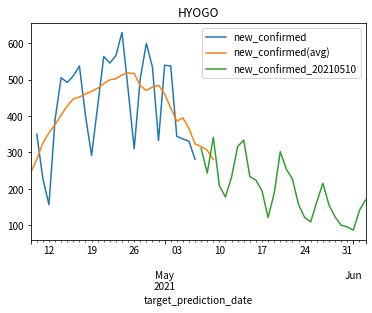

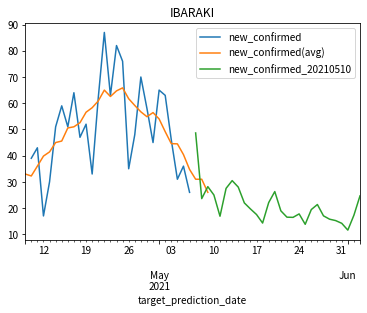

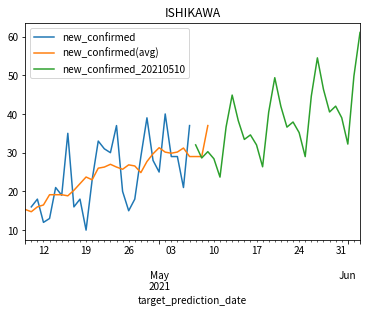

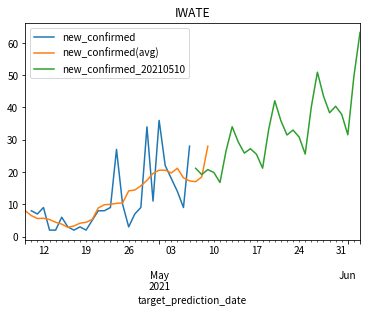

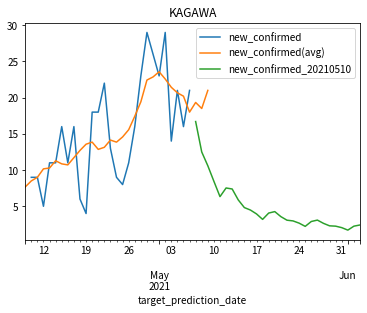

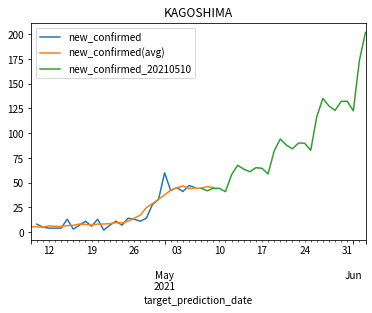

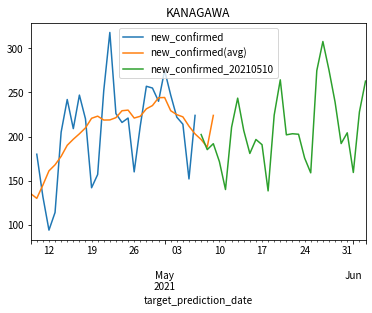

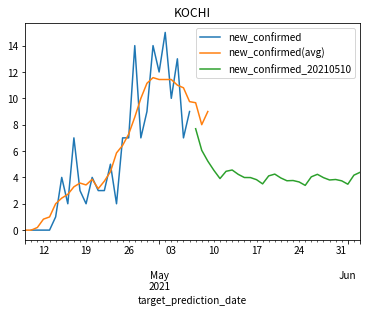

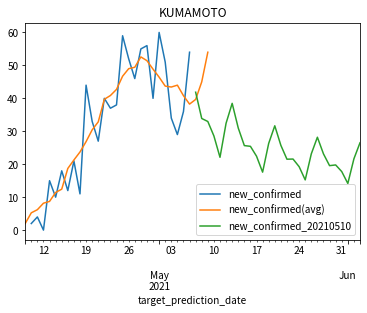

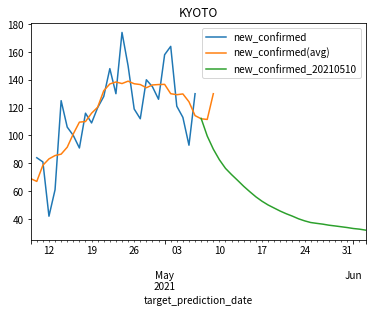

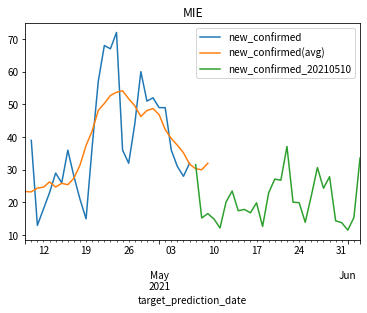

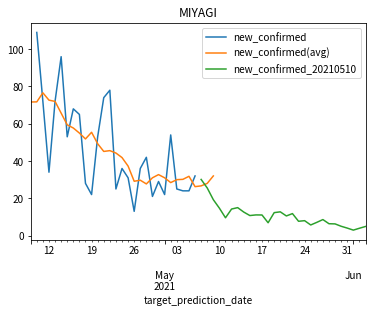

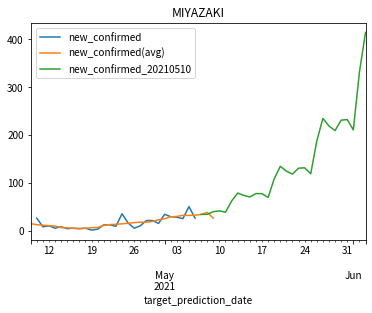

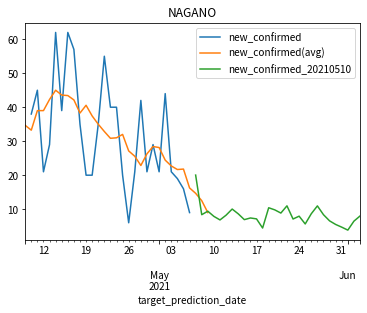

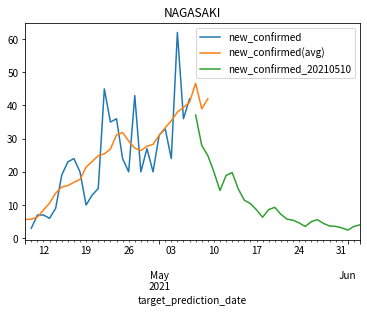

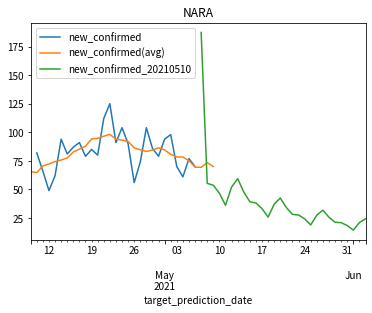

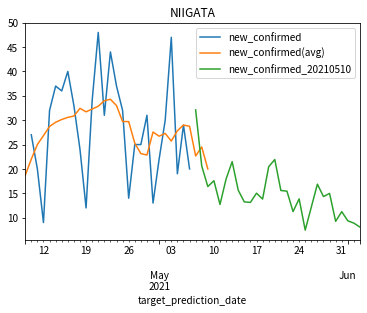

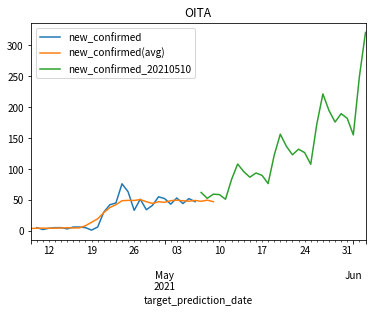

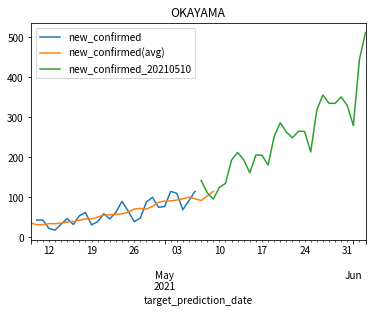

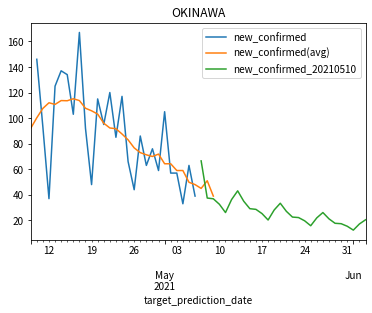

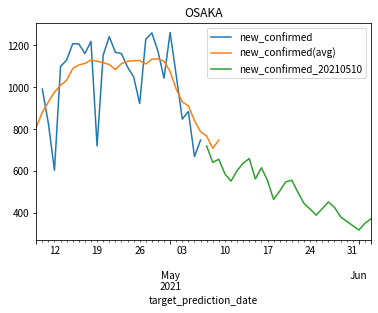

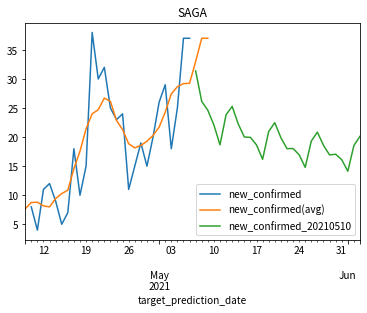

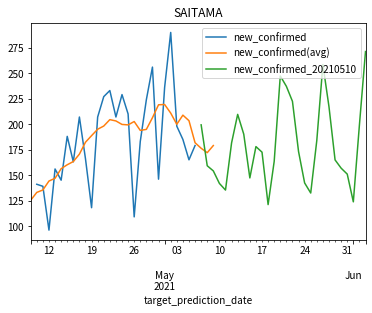

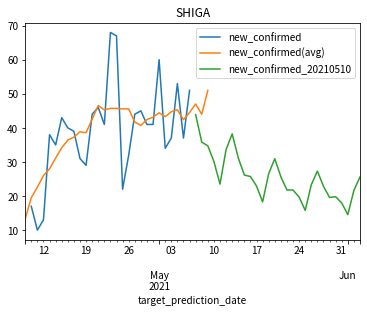

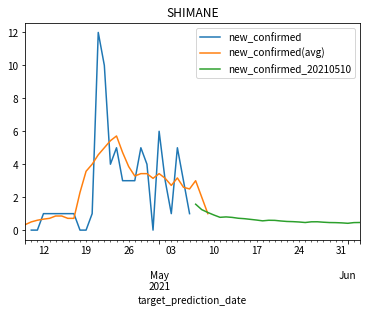

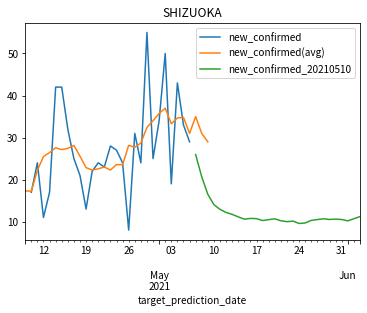

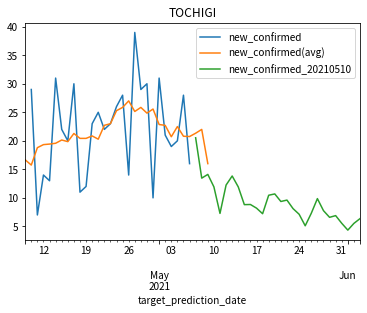

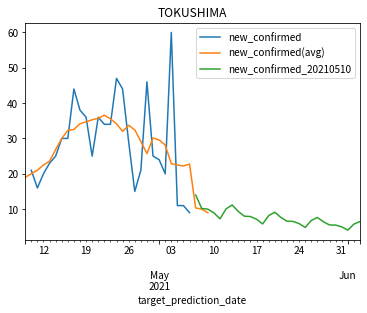

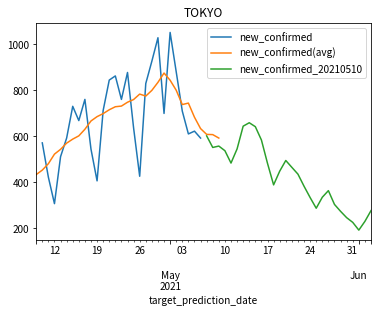

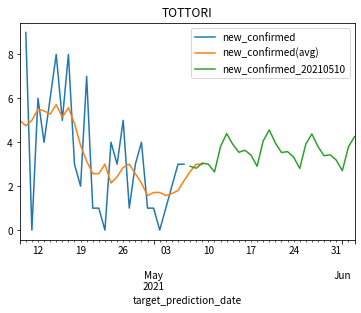

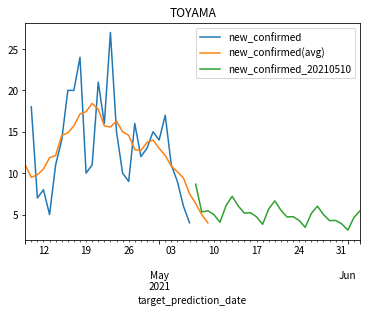

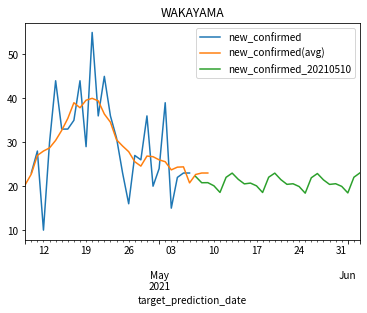

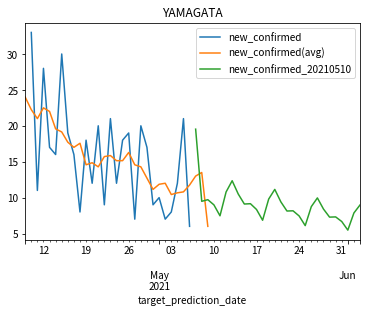

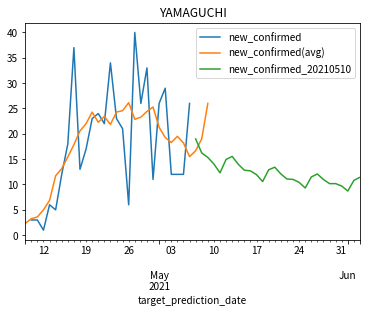

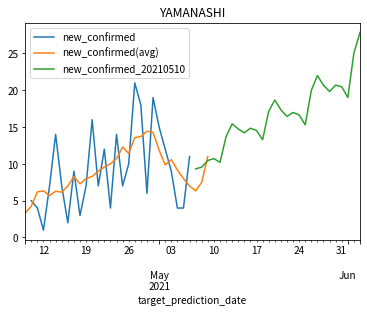

In [15]:
!mkdir -p google-covid19-forecast/jp

ax = weekly_comparison.groupby("target_prediction_date").sum().replace(0, np.nan).plot(title="Japan COVID19 forecast")
display(ax.figure)
plt.savefig("google-covid19-forecast/jp/JPN-weekly.png")
plt.close()



for p, ddf in weekly_comparison.groupby("prefecture_name"):
    ax=ddf.set_index("target_prediction_date").sort_index().plot(title=p)
    display(ax.figure)
    plt.savefig("google-covid19-forecast/jp/%s-weekly.png"%p)
    plt.close()

In [ ]:
!zip google-covid19-forecast.zip google-covid19-forecast/*